In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Particle classification (DL2)

**Recommended datasample(s):**
Datasets of fully-analyzed showers used to obtain Instrument Response Functions, which in the default pipeline workflow are called `gamma3`, `proton2` and `electron`.

**Data level(s):** DL2 (shower geometry + estimated energy + estimated particle classification)

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding particle classification of events which have been completely analyzed.  
In the standard analysis workflow (see documentation), the performance of the separation depends on the energy, so we test it in bins of _reconstructed_ energy.

**Requirements:**

- get a TRAINING file generated using `protopipe-DL2` or the equivalent command from the DIRAC Grid interface

- execute the notebook with `protopipe-BENCHMARK`,

`protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n DL2/benchmarks_DL2_particle-classification`

To obtain the list of all available parameters add `--help-notebook`.

**Development and testing:**  
  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

## Table of contents
   - [Estimate distribution](#Estimate-distribution)
   - [ROC curve](#ROC-curve)
   - [AUC value as a function of energy](#AUC-value-as-a-function-of-energy)
   - [Cut efficiency](#Cut-efficiency)
       - [Fraction of surviving particles as a function of applied gammaness cut](#Fraction-of-surviving-particles-as-a-function-of-applied-gammaness-cut)
       - [Efficiencies correlation](#Efficiencies-correlation)
       - [Efficiency protons cut with fixed gamma efficiency](#Efficiency-protons-cut-with-fixed-gamma-efficiency)

## Imports
[back to top](#Table-of-contents)

In [2]:
import os
from pathlib import Path
import yaml

import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve
import astropy.units as u

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import matplotlib.style as style
from cycler import cycler
%matplotlib inline

from protopipe.pipeline.io import load_config

## Functions
[back to top](#Table-of-contents)

In [3]:
def plot_hist(ax, data, nbin, limit, norm=False, yerr=False, hist_kwargs={}, error_kw={}):
    """Utility function to plot histogram"""
    bin_edges = np.linspace(limit[0], limit[-1], nbin + 1, True)
    y, tmp = np.histogram(data, bins=bin_edges)
    weights = np.ones_like(y)
    if norm is True:
        weights = weights / float(np.sum(y))
    if yerr is True:
        yerr = np.sqrt(y) * weights
    else:
        yerr = np.zeros(len(y))

    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    width = bin_edges[1:] - bin_edges[:-1]
    ax.bar(centers, y * weights, width=width, yerr=yerr, error_kw=error_kw, **hist_kwargs)

    return ax

def plot_roc_curve(ax, model_output, y, **kwargs):
    """Plot ROC curve for a given set of model outputs and labels"""
    fpr, tpr, _ = roc_curve(y_score=model_output, y_true=y)
    roc_auc = auc(fpr, tpr)
    label = '{} (area={:.2f})'.format(kwargs.pop('label'), roc_auc)  # Remove label
    ax.plot(fpr, tpr, label=label, **kwargs)
    return ax

def plot_evt_roc_curve_variation(ax, data_test, cut_list, model_output_name):
    """

    Parameters
    ----------
    ax: `~matplotlib.axes.Axes`
        Axis
    data_test: `~pd.DataFrame`
        Test data
    cut_list: `list`
         Cut list

    Returns
    -------
    ax:  `~matplotlib.axes.Axes`
        Axis
    """
    color = 1.
    step_color = 1. / (len(cut_list))
    for i, cut in enumerate(cut_list):
        c = color - (i + 1) * step_color

        data = data_test.query(cut)
        if len(data) == 0:
            continue

        opt = dict(color=str(c), lw=2, label='{}'.format(cut.replace('reco_energy', 'E')))
        plot_roc_curve(ax, data[model_output_name], data['label'], **opt)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    return ax

# TODO: move to protopipe.benchmarks.utils
def get_fig_size(ratio=None, scale=None):
    ratio = 4/3. if ratio is None else ratio
    scale = 1.0 if scale is None else scale
    height = 5
    width = height * ratio
    return (width*scale, height*scale)

## Load data
[back to top](#Table-of-contents)

In [4]:
# Parametrized cell
# Modify these variables according to your local setup outside of the Vagrant Box
analyses_directory = None
output_directory = Path.cwd() # default output directory for plots
analysis_name = None
load_CTAMARS = False # Enable to compare the CTAN analysis done with CTAMARS (Release 2019)
indir_CTAMARS = None
configuration_file_name = "RandomForestClassifier.yaml"
DL2_gamma = "DL2_tail_gamma_merged.h5"
DL2_proton = "DL2_tail_proton_merged.h5"
DL2_electron = "DL2_tail_electron_merged.h5"
use_seaborn=True
plots_scale = None

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
load_protopipe_previous = False
analysis_name_2 = "v0.4.0_dev1"
use_seaborn = True
matplotlib_settings = {
    "cmap": "cividis",
    "style": "seaborn-colorblind",
    "rc": {"font_size": 8, "font_family": "Fira Sans"},
    "scale": 1.5,
}
seaborn_settings = {
    "theme": {"style": "whitegrid", "context": "talk"},
    "rc_context": {},
    "rc_style": {"xtick.bottom": True, "ytick.left": True},
}
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "DL2",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_filenames = {
    "simtel": "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz",
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/DL2"


In [6]:
input_configuration_file = Path(analyses_directory) / analysis_name / Path("configs") / configuration_file_name
cfg = load_config(input_configuration_file)

if cfg["Method"]["use_proba"] is True:
    model_output = 'gammaness'
    output_range = [0, 1]
else:
    model_output = 'score'
    output_range = [-1, 1]

In [7]:
input_directory = Path(analyses_directory) / analysis_name / Path("data/DL2")

data_selection = 'NTels_reco >= 2'

data_gamma = pd.read_hdf(os.path.join(input_directory, DL2_gamma), "/reco_events").query(data_selection)
data_electron = pd.read_hdf(os.path.join(input_directory, DL2_electron), "/reco_events").query(data_selection)
data_proton = pd.read_hdf(os.path.join(input_directory, DL2_proton), "/reco_events").query(data_selection)

data_gamma['label'] = np.ones(len(data_gamma))
data_electron['label'] = np.zeros(len(data_electron))
data_proton['label'] = np.zeros(len(data_proton))

In [8]:
if load_CTAMARS:
    
    if not indir_CTAMARS:
        try:
            indir_CTAMARS = Path(input_data_CTAMARS["parent_directory"]) / Path(input_data_CTAMARS["DL2"])
        except (NameError, KeyError):
            print("WARNING: CTAMARS data undefined! Please, check the documentation of protopipe-BENCHMARKS.")
    
    input_file_name_CTAMARS = "AUC_vs_Ereco.csv"
    path_mars_AUC_vs_Ereco = indir_CTAMARS / input_file_name_CTAMARS
    
    from numpy import genfromtxt

    CTAMARS_AUC_vs_Ereco = np.genfromtxt(path_mars_AUC_vs_Ereco, 
                                  delimiter=', ', 
                                  dtype=float,
                                  encoding=None)
    CTAMARS_AUC_vs_Ereco = np.stack(CTAMARS_AUC_vs_Ereco, axis=1)

In [9]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

In [10]:
# Plot aesthetics settings

scale = matplotlib_settings["scale"] if plots_scale is None else float(plots_scale)

style.use(matplotlib_settings["style"])
cmap = matplotlib_settings["cmap"]
rc('font', size=matplotlib_settings["rc"]["font_size"])

if matplotlib_settings["style"] == "seaborn-colorblind":
    
    # Change color order to have first ones more readable
    colors_order = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#56B4E9', '#F0E442']
    rc('axes', prop_cycle=cycler(color=colors_order))

if use_seaborn:
    import seaborn as sns
    
    sns.set_theme(context=seaborn_settings["theme"]["context"] if "context" in seaborn_settings["theme"] else "talk",
                  style=seaborn_settings["theme"]["style"] if "style" in seaborn_settings["theme"] else "whitegrid",
                  palette=seaborn_settings["theme"]["palette"] if "palette" in seaborn_settings["theme"] else None,
                  font=seaborn_settings["theme"]["font"] if "font" in seaborn_settings["theme"] else "Fira Sans",
                  font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0,
                  color_codes=seaborn_settings["theme"]["color_codes"] if "color_codes" in seaborn_settings["theme"] else True
                  )
    
    sns.set_style(seaborn_settings["theme"]["style"], rc=seaborn_settings["rc_style"])
    sns.set_context(seaborn_settings["theme"]["context"],
                    font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0)

## Estimate distribution
[back to top](#Table-of-contents)

Only events reconstructed within 1 degree from the center of the camera are selected (point-source analysis) 

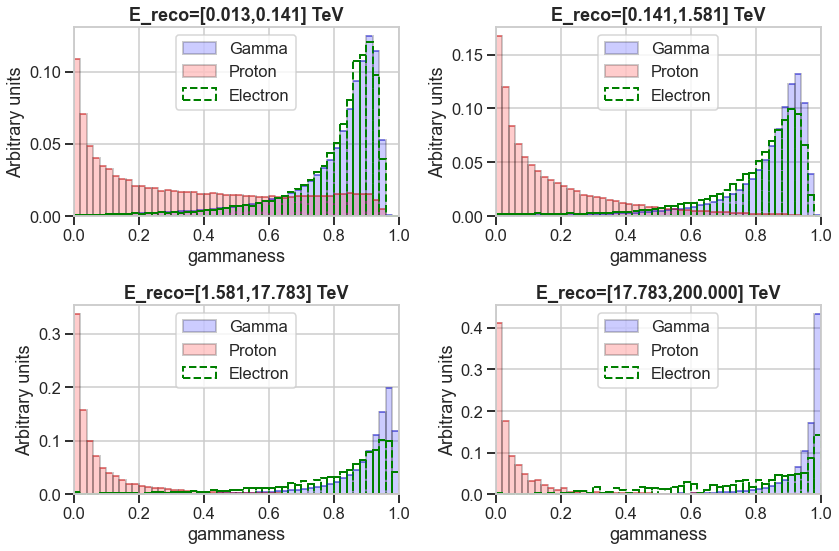

In [11]:
energy_bounds = np.logspace(np.log10(cfg["Diagnostic"]["energy"]["min"]),
                            np.log10(cfg["Diagnostic"]["energy"]["max"]),
                            cfg["Diagnostic"]["energy"]["nbins"] + 1)
angular_cut = 1.0 # degrees


ncols = int(cfg["Diagnostic"]["energy"]["nbins"] / 2)
n_ax = len(energy_bounds) - 1
nrows = int(n_ax / ncols) if n_ax % ncols == 0 else int((n_ax + 1) / ncols)
nrows = nrows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
if nrows == 1 and ncols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx in range(len(energy_bounds) - 1):
    ax = axes[idx]

    # Data selection
    query = 'reco_energy >= {} and reco_energy < {}'.format(energy_bounds[idx], energy_bounds[idx + 1])
    gamma = data_gamma.query(query + ' and offset < {}'.format(angular_cut))
    proton = data_proton.query(query + ' and offset < {}'.format(angular_cut))
    electron = data_electron.query(query + ' and offset < {}'.format(angular_cut))
    data_list = [gamma, proton, electron]
    
    # Graphical stuff
    color_list = ['blue', 'red', 'green']
    edgecolor_list = ['black', 'black', 'green']
    fill_list = [True, True, False]
    ls_list = ['-', '-', '--']
    lw_list = [2, 2, 2]
    alpha_list = [0.2, 0.2, 1]
    label_list = ['Gamma', 'Proton', 'Electron']
    
    opt_list = []
    err_list = []
    for jdx, data in enumerate(data_list):
        opt_list.append(dict(edgecolor=edgecolor_list[jdx], color=color_list[jdx], fill=fill_list[jdx], ls=ls_list[jdx], lw=lw_list[jdx], alpha=alpha_list[jdx], label=label_list[jdx]))
        err_list.append(dict(ecolor=color_list[jdx], lw=lw_list[jdx], alpha=alpha_list[jdx], capsize=3, capthick=2,))
    
    for jdx, data in enumerate(data_list):
        ax = plot_hist(
            ax=ax, data=data[model_output], nbin=50, limit=output_range,
            norm=True, yerr=False,
            hist_kwargs=opt_list[jdx],
            error_kw=err_list[jdx],
        )
    ax.set_title('E_reco=[{:.3f},{:.3f}] TeV'.format(energy_bounds[idx], energy_bounds[idx + 1]), fontdict={'weight': 'bold'})
    ax.set_xlabel(model_output)
    ax.set_ylabel('Arbitrary units')
    ax.set_xlim(output_range)
    ax.legend(loc='upper center')
    ax.grid(visible=True)
    
plt.tight_layout()

fig.savefig(plots_folder / f"DL2_particle_classification_estimate_distribution_vs_reco_energy_protopipe_{analysis_name}.png")

plt.show()

## ROC curve
[back to top](#Table-of-contents)

Bins in reconstructed energy

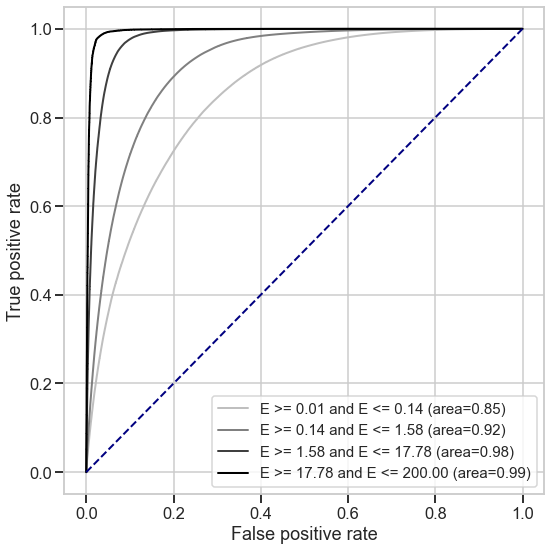

In [12]:
data = pd.concat([data_gamma, data_electron, data_proton])

plt.figure(figsize=(8,8))

ax = plt.gca()

cut_list = ['reco_energy >= {:.2f} and reco_energy <= {:.2f}'.format(
    energy_bounds[i], # should be fixed in master
    energy_bounds[i+1] # should be fixed in master
) for i in range(len(energy_bounds) - 1)]

plot_evt_roc_curve_variation(ax, data, cut_list, model_output)

ax.legend(loc='lower right', fontsize='small')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
plt.tight_layout()

fig.savefig(plots_folder / f"DL2_particle_classification_roc_curve_protopipe_{analysis_name}.png")

plt.show()

## AUC value as a function of energy
[back to top](#Table-of-contents)

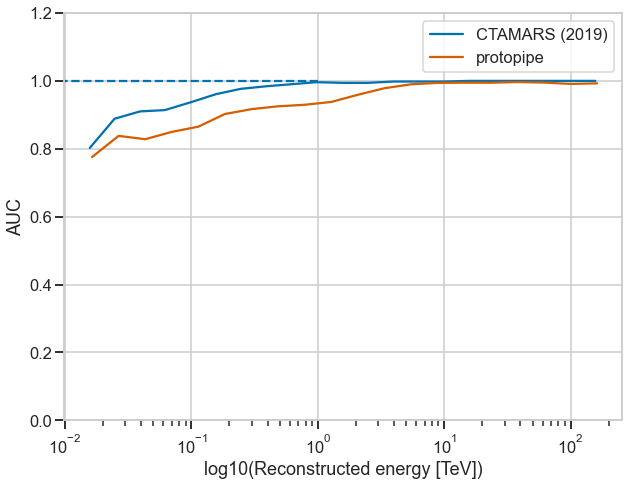

In [13]:
plt.figure(figsize=get_fig_size(ratio=4./3., scale=scale))

aucs = []
reco_energy = []

reconstructed_energy_bins_edges = np.logspace(np.log10(cfg["Diagnostic"]["energy"]["min"]),
                            np.log10(cfg["Diagnostic"]["energy"]["max"]),
                            21) * u.TeV

for i in range(len(reconstructed_energy_bins_edges)-1):

    cut_in_energy = f"(reco_energy > {reconstructed_energy_bins_edges[i].value:.2f}) & (reco_energy < {reconstructed_energy_bins_edges[i+1].value:.2f})"
    reco_energy.append( 0.5 * (reconstructed_energy_bins_edges[i].value + reconstructed_energy_bins_edges[i+1].value) )

    selected_showers = data.query(cut_in_energy)

    fpr, tpr, _ = roc_curve(y_score=selected_showers["gammaness"],
                            y_true=selected_showers["label"])
    roc_auc = auc(fpr, tpr)

    aucs.append(roc_auc)


plt.hlines(1,
           xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1],
           linestyles="dashed")
plt.ylim(0,1.2)
plt.xscale("log")
plt.xlabel("log10(Reconstructed energy [TeV])")
plt.ylabel("AUC")
plt.grid(visible=True)

if load_CTAMARS:
    plt.plot((10**CTAMARS_AUC_vs_Ereco[0])/10**3,
             CTAMARS_AUC_vs_Ereco[1],
             label=f"{input_data_CTAMARS['label']}")
    plt.plot(reco_energy, aucs, label="protopipe")
    plt.legend()
else:
    plt.plot(reco_energy, aucs)

fig.savefig(plots_folder / f"DL2_particle_classification_AUC_vs_Ereco_protopipe_{analysis_name}.png")

## Cut efficiency
[back to top](#Table-of-contents)

For assessing the quality of the separation we plot the fraction of surviving gammas and protons as a function of the applied gammaness cut.

We use the ``gamma-3`` and the ``proton-2`` samples (those used also to calculate the final performance), and keeping only events reconstructed within 1 degree of the FoV center (since the source is at the center, we restrict the test to the protons which are actually be reconstructed around it, which are those we need to suppress to improve the sensitivity of the array).

The performance of the separation depends on the energy, so we test it in bins of **reconstructed** energy around 1 TeV.

### Fraction of surviving particles as a function of applied gammaness cut
[back to top](#Table-of-contents)

CTAMARS comparison enabled: using 'hadronness' definition instead of 'gammaness'.


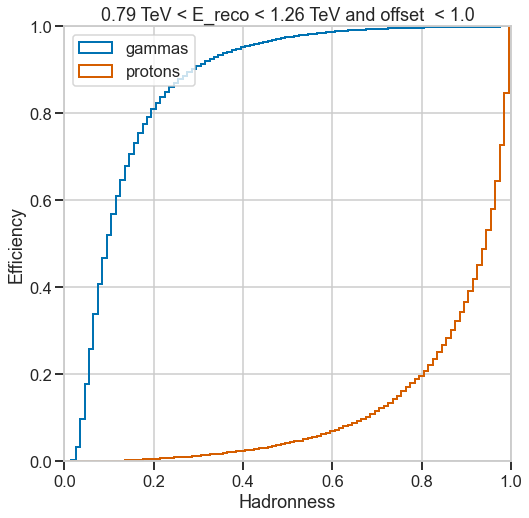

In [14]:
plt.figure(figsize=(8,8))

opt = {"bins":100,
       "density":True,
       "histtype":'step',
       "cumulative":True,
       "align": "right",
       "lw": 2,
       "range": [0,1]}

min_energy = (10**2.9 * u.GeV).to("TeV")
max_energy = (10**3.1 * u.GeV).to("TeV")

max_distance_center_FoV = 1 * u.deg
energy_cut = f"reco_energy > {min_energy.value} and reco_energy < {max_energy.value}"
angular_cut = f" and offset < {max_distance_center_FoV.value}"
total_cut = energy_cut + angular_cut

if load_CTAMARS: # use "hadronness" definition
    print("CTAMARS comparison enabled: using 'hadronness' definition instead of 'gammaness'.")
    gamma_efficiencies = plt.hist(1 - data_gamma.query(total_cut)["gammaness"], label="gammas", **opt)
    proton_efficiencies = plt.hist(1 - data_proton.query(total_cut)["gammaness"], label="protons", **opt)
    plt.xlabel("Hadronness")
else:
    gamma_efficiencies = plt.hist(data_gamma.query(total_cut)["gammaness"], label="gammas", **opt)
    proton_efficiencies = plt.hist(data_proton.query(total_cut)["gammaness"], label="protons", **opt)
    plt.xlabel("Gammaness")
plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.ylabel("Efficiency")

plt.grid(visible=True)
plt.title(f"{min_energy:.2f} < E_reco < {max_energy:.2f} and offset  < {max_distance_center_FoV.value}")
plt.legend(loc="upper left")
None

### Efficiencies correlation
[back to top](#Table-of-contents)

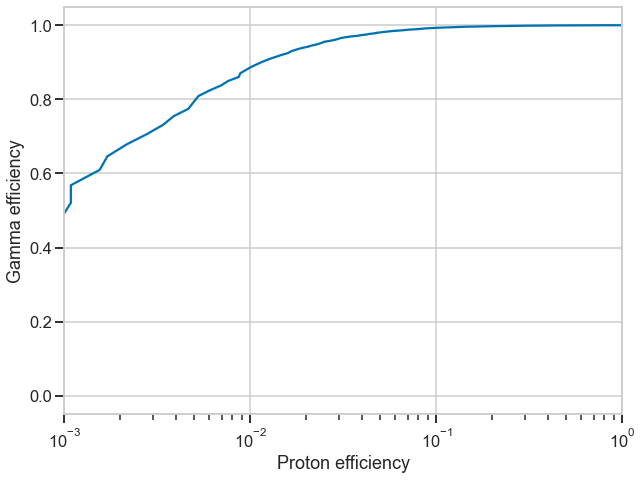

In [15]:
plt.figure(figsize=get_fig_size(ratio=4./3., scale=scale))
plt.plot(proton_efficiencies[0],gamma_efficiencies[0])
plt.xscale("log")
plt.ylabel("Gamma efficiency")
plt.xlabel("Proton efficiency")
plt.grid(visible=True)
if load_CTAMARS:
    plt.xlim(1.e-3, 1)
None

### Efficiency protons cut with fixed gamma efficiency
[back to top](#Table-of-contents)

We apply a gamma efficiency cut of 90%.

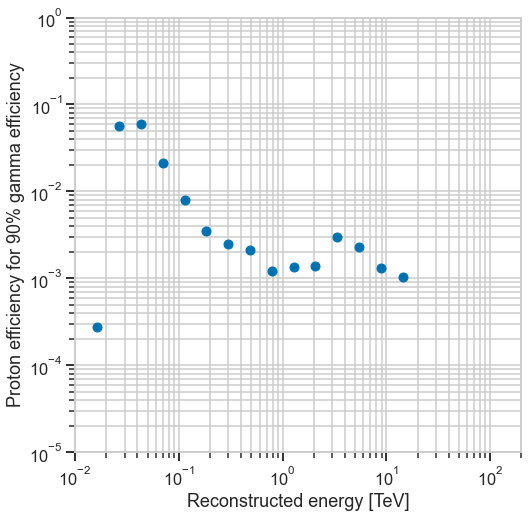

In [16]:
plt.figure(figsize=(8,8))

reco_energy = []
efficiency_protons = []
for i in range(len(reconstructed_energy_bins_edges)-1):
    
    cut_in_energy = f"(reco_energy > {reconstructed_energy_bins_edges[i].value:.2f}) & (reco_energy < {reconstructed_energy_bins_edges[i+1].value:.2f})"
    reco_energy.append( 0.5 * (reconstructed_energy_bins_edges[i].value + reconstructed_energy_bins_edges[i+1].value) )
    
    efficiency_cut = np.quantile(data_gamma.query(cut_in_energy + angular_cut)["gammaness"], 0.9)
    efficiency_protons.append(len(data_proton.query(cut_in_energy + angular_cut + " and gammaness > 0.9"))/len(data_proton.query(cut_in_energy + angular_cut)))

plt.plot(reco_energy, efficiency_protons, "o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Proton efficiency for 90% gamma efficiency")
plt.grid(which="both", visible=True)
plt.ylim(1.e-5, 1)
if load_CTAMARS:
    plt.xlim(0.01, 200)
None